# Synthetic data test using the CRUST1.0 model and a homogeneous density-contrast

This notebook runs a similar test to [`synthetic-crust1-south-america.ipynb`](synthetic-crust1-south-america.ipynb) using the CRUST1.0 model. But this time we'll use a model with a homogeneous density-contrast along the Moho.

The purpose of this test is to verify if our cross-valiation approach is able to estimate the true values of the reference level and the density-contrast (assuming that it is homogeneous). In the [`synthetic-crust1-south-america.ipynb`](synthetic-crust1-south-america.ipynb) notebook we ran an inversion assuming a homogeneous density-contrast when in fact the true density-contrast varied along the Moho. Thus, we could not verify if our estimate of the density-contrast is correct. For that, we'll need to use a true model with a homogeneous density-contrast.

## Package imports

Load the necessary libraries to run the inversion and make graphs.

In [2]:
# Insert the plots into the notebook
%matplotlib inline

Load the standard scientific Python stack to numerical analysis and plotting.

In [3]:
from __future__ import division
import cPickle as pickle
import itertools
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import multiprocessing
import seaborn  # Makes the default style of the plots nicer

The computations generate a lot of run-time warnings. They aren't anything to be concerned about so disable them to avoid clutter.

In [4]:
import warnings
warnings.simplefilter('ignore')

Load the required modules from [Fatiando a Terra](http://www.fatiando.org).

In [5]:
from fatiando.vis import mpl
from fatiando.gravmag import tesseroid
from fatiando import gridder, utils
from fatiando.inversion import Smoothness2D
import fatiando

In [6]:
print("Version of Fatiando a Terra used: {}".format(fatiando.__version__))

Version of Fatiando a Terra used: 3aed3f5676a45705b598bfc72f9883043097c854


Load our custom classes and functions.

In [7]:
from tesseroid_mesh import TesseroidRelief
from datasets import fetch_assumpcao_moho_points, fetch_crust1
from moho import MohoGravityInvSpherical, make_mesh

Get the number of cores in this computer to run the some things in parallel.

In [8]:
ncpu = multiprocessing.cpu_count()
print("Number of cores: {}".format(ncpu))

Number of cores: 8


## Load the CRUST1 model for South America

Get the CRUST1.0 data from the archive file and cut it to South America.

In [9]:
crust1 = fetch_crust1('../data/crust1.0.tar.gz').cut((-60, 20, -90, -30))

Establish a reference level for the Moho of the Normal Earth (given as height above the ellipsoid in meters, thus it is negative).

In [10]:
reference = -30e3

Create a `TesseroidRelief` model of the Moho using a homogeneous density-contrast so that we can use in forward modeling.

In [11]:
moho_density_contrast = 350

In [12]:
model = TesseroidRelief(crust1.area, crust1.shape, relief=-crust1.moho_depth.ravel(), reference=reference)
density = moho_density_contrast*np.ones(model.size)
density[model.relief < model.reference] *= -1
model.addprop('density', density)

Make a plot of the Moho depth using an appropriate map projection.

In [13]:
bm = Basemap(projection='cyl', 
             llcrnrlon=crust1.area[2], urcrnrlon=crust1.area[3], 
             llcrnrlat=crust1.area[0], urcrnrlat=crust1.area[1],
             resolution='l')

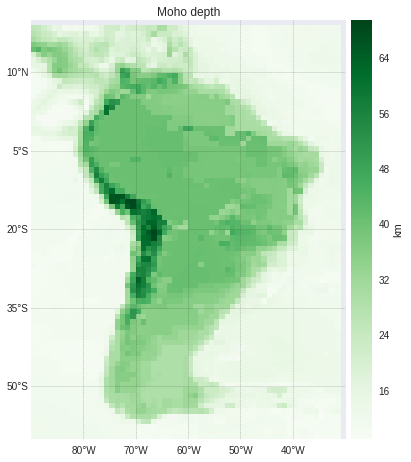

In [14]:
x, y = bm(model.lon.reshape(model.shape), model.lat.reshape(model.shape))

plt.figure(figsize=(7, 6))
plt.title('Moho depth')
bm.pcolormesh(x, y, -0.001*model.relief.reshape(model.shape), cmap='Greens')
plt.colorbar(pad=0.01).set_label('km')
bm.drawmeridians(np.arange(-80, -30, 10), labels=[0, 0, 0, 1], linewidth=0.2)
bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0.2)
plt.tight_layout(pad=0)

## Generate synthetic data

Generate the computation grid for our synthetic dataset. The grid will have half the spacing of the model. This way, we'll have more points than we'll need to run the inversion. The extra points will be separated into a *test dataset* for cross-validation (see section [Cross-validation](#Cross-validation) below).

In [15]:
# clon and clat are the coordinates of the center of each model cell
area = [model.clat.min(), model.clat.max(), model.clon.min(), model.clon.max()]
# Increase the shape to have half the grid spacing
full_shape = [s*2 - 1 for s in model.shape]
grid_height = 50e3
full_lat, full_lon, full_height = gridder.regular(area, full_shape, z=grid_height)
print('Number of grid points: {} x {} = {}'.format(full_shape[0], full_shape[1], full_shape[0]*full_shape[1]))
print('Grid height: {} m'.format(grid_height))

Number of grid points: 159 x 119 = 18921
Grid height: 50000.0 m


Calculate the synthetic data and contaminate it with pseudo-random gaussian noise.

In [16]:
full_data_noisefree = tesseroid.gz(full_lon, full_lat, full_height, model, njobs=ncpu)
full_data = utils.contaminate(full_data_noisefree, 5, seed=0)

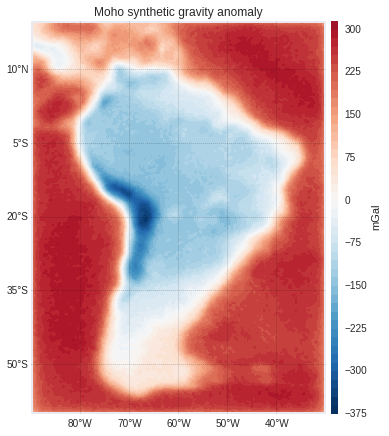

In [17]:
x, y = bm(full_lon, full_lat)
ranges = np.abs([full_data.min(), full_data.max()]).max()

plt.figure(figsize=(7, 6))
plt.title('Moho synthetic gravity anomaly')
bm.contourf(x, y, full_data, 60, tri=True, cmap='RdBu_r', vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=50).set_label('mGal')
bm.drawmeridians(np.arange(-80, -30, 10), labels=[0, 0, 0, 1], linewidth=0.2)
bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0.2)
plt.tight_layout()

## Cross-validation

First, we must separate the dataset into two parts: one for the inversion, another for cross-validation. The inversion dataset will have double the grid spacing and (for this test) must fall on top of each grid cell. The remaining data will be used for cross-validation.

In [18]:
def split_data(data, shape, every):
    data = [i.reshape(shape) for i in data]
    # Take every "every" points for the inversion
    inversion = [i[::every, ::every] for i in data]
    # mask marks the grid points I didn't take for inversion
    mask = np.ones(shape, dtype=np.bool)
    mask[::every, ::every] = False  # These are the ones I took
    test = [i[mask] for i in data]
    shape = inversion[0].shape
    # Sanity checks
    assert all(t.size + i.size == d.size for t, i, d in zip(test, inversion, data)), \
        "Number of points in inversion + test set different from original data."
    assert all(t.size == test[0].size for t in test), "Test set has differet number of points"
    assert all(i.size == inversion[0].size for i in inversion), "Inversion set has differet number of points"
    assert all(i.shape == inversion[0].shape for i in inversion), "Inversion set has differet shape"
    # Print some info
    print("Number of inversion grid points: {} x {} = {}".format(shape[0], shape[1], shape[0]*shape[1]))
    print("Number of test set points: {}".format(test[0].size))
    return [i.ravel() for i in inversion], test, shape

In [19]:
inversion_set, test_set, shape = split_data([full_lat, full_lon, full_height, full_data], full_shape, every=2)

Number of inversion grid points: 80 x 60 = 4800
Number of test set points: 14121


Test if the inversion set falls on top of the model cells.

In [20]:
lat, lon, height, data = inversion_set
assert np.allclose(model.clon.ravel(), lon, rtol=1e-10, atol=0)
assert np.allclose(model.clat.ravel(), lat, rtol=1e-10, atol=0)

No errors means that both checks (`assert`) passed.

Define the scoring function.

In [21]:
def score_test_set(model, lat, lon, height, data, njobs=1):
    predicted = tesseroid.gz(lon, lat, height, model, njobs=njobs)
    score = np.sum((predicted - data)**2)/data.size
    return score

Check if the score for the true model and error free data is 0 (perfect fit).

In [22]:
score_test_set(model, full_lat, full_lon, full_height, full_data_noisefree, njobs=ncpu)

0.0

For this test, we'll assume that we **don't know the true reference level used or density contrast**. We'll try to estimate both through cross-validation. This means that there will be **two types of cross-validation**: 

1. Testing agains the `test_set` for the regularization parameter
2. Testing against some other constraints for the reference level and density contrast

These "other constraints" will come some point information about the Moho depth in some isolated points. In reality, these point depths could come from seismic experiments.

We'll generate some fictional point constraints by taking the true value from our Moho model. The point coordinates chosen for this come from the seismic dataset of [Assumpção et al. (2012)](http://dx.doi.org/10.1016%2Fj.tecto.2012.11.014). We'll interpolate the values of the CRUST1 Moho depth onto these points.

In [23]:
lat_points, lon_points = fetch_assumpcao_moho_points('../data/Moho_Map_SAm2013_data.tar.gz')[:2]

In [24]:
seismic_points = gridder.interp_at(model.clat.ravel(), model.clon.ravel(), model.relief, 
                                   lat_points, lon_points)

In [25]:
test_points = [lat_points, lon_points, seismic_points]

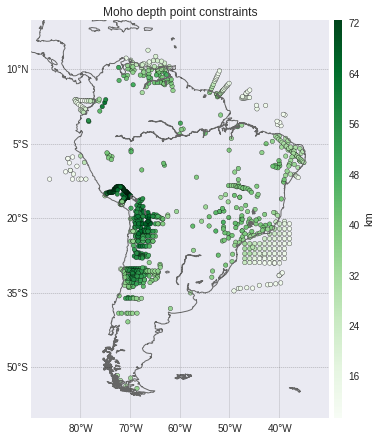

In [26]:
x, y = bm(lon_points, lat_points)

plt.figure(figsize=(7, 6))
plt.title('Moho depth point constraints')
bm.scatter(x, y, c=-0.001*seismic_points, s=20, cmap='Greens')
plt.colorbar(pad=0.01, aspect=50).set_label('km')
bm.drawmeridians(np.arange(-80, -30, 10), labels=[0, 0, 0, 1], linewidth=0.2)
bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0.2)
bm.drawcoastlines(color="#666666")
plt.tight_layout()

Now we need a scoring function function for the seismic contraints (`test_points`). This function will calculate the Mean Square Error (MSE) between the estimated depth and the "seismic" constraints for a given a Moho depth estimate.

In [27]:
def seismic_residuals(moho, lat, lon, height):
    """
    Calculate the residuals between the estimated *moho* (a TesseroidRelief)
    and the point constrains (lat, lon, height).
    
    Values are interpolated onto (lat, lon) for comparison.
    """
    estimated = gridder.interp_at(moho.clat.ravel(), moho.clon.ravel(), moho.relief, 
                                  lat, lon, extrapolate=True)
    return estimated - height
    
def score_seismic_constraints(moho, lat, lon, height):
    """
    Return the MSE between the moho estimate and the point constraints.
    """
    residuals = seismic_residuals(moho, lat, lon, height)
    mse = np.sum(residuals**2)/height.size
    return mse

We can check if our function works by feeding it the true model and the extracted points. The MSE should be zero.

In [28]:
score_seismic_constraints(model, lat_points, lon_points, seismic_points)

0.0

Now we need functions to perform both types of cross-validation.

In [29]:
def fit_all(solvers, njobs=1): 
    """
    Run ``fit`` for all solvers using *njobs* processes.
    """
    if njobs > 1:
        pool = multiprocessing.Pool(njobs)
        results = pool.map(call_fit, solvers)
        pool.close()
        pool.join()
    else:
        results = map(call_fit, solvers)
    return results

def call_fit(solver):
    """
    Call the ``fit`` method of a solver object.
    If any exceptions arise, returns None.
    """
    try:
        solver.fit()
    except:
        solver = None
    return solver

In [55]:
def score_all(solutions, test_data, points, njobs=1):
    """
    Get the cross-validation score for all solutions using *njobs* processes.
    
    If points is True, will score against the seismic point constraints.
    Otherwise, score against the test dataset.
    """
    args = [[s.estimate_, test_data, points] for s in solutions]
    if njobs > 1:
        pool = multiprocessing.Pool(njobs)
        results = pool.map(call_score, args)
        pool.close()
        pool.join()
    else:
        results = map(call_score, args)
    return np.array(results)

def call_score(args):
    """
    Call score_test_set or score_seismic_constraints on the solution.
    
    Needed because multiprocessing.Pool.map only allows functions with
    a single argument.
    """
    solution, test_data, points = args
    try:
        if points:
            score = score_seismic_constraints(solution, *test_data)
        else:
            score = score_test_set(solution, *test_data)
    except:
        score = np.nan
    return score

## Inversion setup

We need to generate a `TesseroidRelief` mesh for the inversion, give it a reference level and a density contrast. We'll assume that our mesh has the same geometry of the true model so that we can better compare the estimated and true Moho reliefs.

In [31]:
mesh = model.copy(deep=True)

We'll also need an initial estimate, the solver and its configuration, and a regularization object.

In [32]:
misfit = MohoGravityInvSpherical(lat, lon, height, data, mesh)
regul = Smoothness2D(mesh.shape)
initial = -60e3*np.ones(mesh.size)  # The initial estimate doesn't really matter too much
config = dict(method='newton', initial=initial, tol=0.2, maxit=15)

## Plotting functions

We'll define some plotting functions here to avoid having all this code down with the results. You can safely skip (not read) this section because we only define the functions here. They are called after the inversion below.

In [66]:
def plot_fit(lat, lon, data, solution, bm):    
    ranges = np.abs([data.max(), data.min()]).max()
    
    plt.figure(figsize=(7, 6))
    plt.title('Observed (color) and predicted (contour) data')    
    levels = mpl.contourf(lon, lat, data, shape, 40, cmap='RdBu_r', basemap=bm, 
                          vmin=-ranges, vmax=ranges)
    plt.colorbar(pad=0.01).set_label('mGal')
    mpl.contour(lon, lat, solution[0].predicted(), shape, levels, 
                basemap=bm, color='#333333')
    bm.drawmeridians(np.arange(-80, -30, 10), labels=[0, 0, 0, 1], linewidth=0.2)
    bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0.2)
    plt.tight_layout(pad=0)
    
def plot_residuals(solution):
    residuals = solution[0].residuals()
    
    plt.figure(figsize=(3, 2.5))
    plt.text(0.65, 0.8, 
             "mean = {:.2f}\nstd = {:.2f}".format(residuals.mean(), residuals.std()), 
             transform=plt.gca().transAxes)
    plt.hist(residuals, bins=20, normed=True, histtype='stepfilled')
    plt.xlabel('Residuals (mGal)')
    plt.ylabel('Normalized frequency')
    plt.tight_layout(pad=0)
    
def plot_estimate(solution, bm):
    moho = solution.estimate_
    x, y = bm(moho.lons, moho.lats)
    
    plt.figure(figsize=(7, 6))
    plt.title("Estimated Moho depth")
    bm.pcolormesh(x, y, -0.001*moho.relief.reshape(moho.shape), cmap='Greens')
    plt.colorbar(pad=0.01).set_label('km')
    bm.drawmeridians(np.arange(-80, -30, 10), labels=[0, 0, 0, 1], linewidth=0.2)
    bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0.2)
    plt.tight_layout(pad=0)

def plot_diff(solution, model, bm):
    moho = solution.estimate_
    diff = -0.001*(model.relief - moho.relief).reshape(moho.shape)
    ranges = np.abs([diff.max(), diff.min()]).max()
    x, y = bm(moho.lons, moho.lats)
    
    plt.figure(figsize=(7, 6))
    plt.title("Difference between true and estimated")  
    bm.pcolormesh(x, y, diff, cmap='RdYlBu_r', vmin=-ranges, vmax=ranges)
    plt.colorbar(pad=0.01).set_label('km')
    bm.drawmeridians(np.arange(-40, 45, 20), labels=[0, 0, 0, 1], linewidth=0)
    bm.drawparallels(np.arange(20, 65, 20), labels=[1, 0, 0, 0], linewidth=0)
    plt.tight_layout(pad=0)
    
def plot_diff_hist(solution, model):
    moho = solution.estimate_
    diff = -0.001*(model.relief - moho.relief)
    
    plt.figure(figsize=(3, 2.5))
    plt.title('Difference (true model)')
    plt.text(0.65, 0.8, 
             "mean = {:.2f}\nstd = {:.2f}".format(diff.mean(), diff.std()), 
             transform=plt.gca().transAxes) 
    # Use the line above so the text coordinates are in axes coordinates (0 to 1)
    # instead of data coordinates, which may vary between runs.
    plt.hist(diff.ravel(), bins=20, normed=True, histtype='stepfilled')
    plt.xlabel('Differences (km)')
    plt.ylabel('Normalized frequency')
    plt.tight_layout(pad=0)
    
def plot_diff_seismic(solution, test_points, bm):
    moho = solution.estimate_
    x, y = bm(moho.lons, moho.lats)
    diff = -0.001*seismic_residuals(moho, *test_points)
    ranges = np.abs([diff.max(), diff.min()]).max()
    lat, lon, depth = test_points
    xp, yp = bm(lon, lat)
   
    fig = plt.figure(figsize=(7, 6))
    bm.pcolormesh(x, y, -0.001*moho.relief.reshape(moho.shape), cmap='Greens')
    plt.colorbar(pad=0.01, aspect=50).set_label('Estimated Moho depth (km)')
    bm.scatter(xp, yp, c=diff, s=40, cmap='PuOr_r', 
                     vmin=-ranges, vmax=ranges, linewidths=0.1)
    cb = plt.colorbar(pad=0.01, aspect=50)
    cb.set_label('Difference between estimated and seismic (km)')
    bm.drawmeridians(np.arange(-80, -30, 10), labels=[0, 0, 1, 0], linewidth=0.2)
    bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0.2)
    plt.tight_layout(pad=0)
    
def plot_diff_seismic_hist(solution, test_points):
    moho = solution.estimate_
    diff = -0.001*seismic_residuals(moho, *test_points)

    plt.figure(figsize=(3, 2.5))
    plt.title('Difference (seismic points)')
    plt.text(0.65, 0.8, 
             "mean = {:.2f}\nstd = {:.2f}".format(diff.mean(), diff.std()), 
             transform=plt.gca().transAxes)
    # Use the line above so the text coordinates are in axes coordinates (0 to 1)
    # instead of data coordinates, which may vary between runs.
    plt.hist(diff, bins=20, normed=True, histtype='stepfilled')
    plt.xlabel('Differences (km)')
    plt.ylabel('Normalized frequency')
    plt.tight_layout(pad=0)

def plot_cv_regul(regul_params, scores, best, log=True): 
    plt.figure(figsize=(5, 3))
    plt.title('Cross-validation (regularization parameter)')
    plt.plot(regul_params, scores, marker='o')
    plt.plot(regul_params[best], scores[best], 's', markersize=10, 
             color=seaborn.color_palette()[2], label='Minimum')
    plt.legend(loc='upper left')
    plt.xscale('log')
    if log:
        plt.yscale('log')
    plt.xlabel('Regularization parameter')
    plt.ylabel(u'Mean Square Error')
    plt.tight_layout(pad=0)
    
def plot_cv_ref_dens(densities, referece_levels, scores, best_dens, best_ref):
    plt.figure(figsize=(5, 3))
    plt.title('Cross-validation (reference level and density)')
    plt.contourf(-0.001*reference_levels, densities, scores, 30, cmap='BuPu_r')
    plt.colorbar(pad=0.01).set_label('Mean Square Error')
    plt.plot(-0.001*referece_levels[best_ref], densities[best_dens], 's', markersize=10, 
             color=seaborn.color_palette()[2], label='Minimum')
    l = plt.legend(loc='upper left')
    for txt in l.get_texts():
        txt.set_color('#ffffff')
    plt.xlabel('Reference level (km)')
    plt.ylabel(u'Density contrast (kg/m³)')
    plt.tight_layout(pad=0)
    
def plot_convergence(solution, log=True):
    plt.figure(figsize=(5, 3))
    plt.title('Convergence')
    plt.plot(range(solution.stats_['iterations'] + 1), solution.stats_['objective'])
    plt.xlabel('Iteration')
    plt.ylabel('Goal function')
    if log:
        plt.yscale('log')
    plt.tight_layout(pad=0)

## Run the inversion and cross-validations

These are the values of the regularization parameter, reference level, and density contrast that we'll use.

In [71]:
regul_params = np.logspace(-7, -2, 8)
regul_params

array([  1.00000000e-07,   3.72759372e-07,   1.38949549e-06,
         5.17947468e-06,   1.93069773e-05,   7.19685673e-05,
         2.68269580e-04,   1.00000000e-03])

In [72]:
reference_levels = np.arange(-35e3, -20e3 + 1, 5000)
reference_levels

array([-35000., -30000., -25000., -20000.])

In [98]:
densities = np.arange(200, 500 + 1, 100)
densities

array([200, 300, 400, 500])

First, run the cross-validation to find the regularization parameter. We'll use one of the values for the reference and density contrast. The value of the regularization parameter that we estimate here will be used in the second cross-validation to find the density contrast and reference level.

In [74]:
misfit.set_density(densities[-1]).set_reference(reference_levels[-1])

Run the inversion for each value in `regul_params` (in parallel using all available cores). 

In [75]:
%time solutions_regul = fit_all([(misfit + mu*regul).config(**config) for mu in regul_params], njobs=ncpu)

CPU times: user 528 ms, sys: 208 ms, total: 736 ms
Wall time: 10min 41s


Score the results against the test dataset.

In [76]:
%time scores_regul = score_all(solutions_regul, test_set, points=False, njobs=ncpu)

CPU times: user 172 ms, sys: 84 ms, total: 256 ms
Wall time: 2min 50s


The best solution is the one with the smallest cross-validation score.

In [77]:
best_regul = np.argmin(scores_regul)

We'll use this solution as the inversion solver for the next cross-validation (for the reference level and density).

In [78]:
solver = solutions_regul[best_regul]

But first, let's take a look at the current solution.

Plot the cross-validation scores.

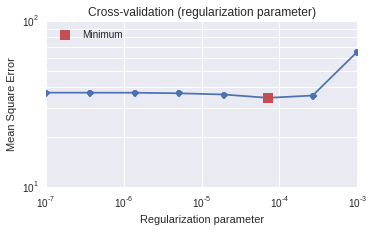

In [79]:
plot_cv_regul(regul_params, scores_regul, best_regul, log=True)
plt.grid(True, which='both', axis='y')

The inversion residuals (to see if the solution fits the data).

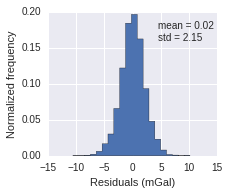

In [80]:
plot_residuals(solver)

The solution itself to see if it is smooth enough.

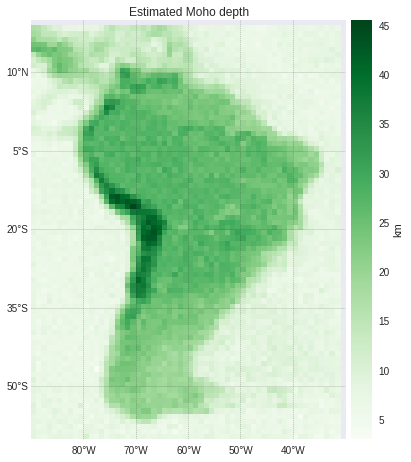

In [81]:
plot_estimate(solver, bm)

Now, run the second cross-validation to estimate the density-contrast and the reference level.

In [82]:
def set_ref_dens(solver, ref, dens):
    """
    Configure the solver to use this reference level and density.
    """
    res = solver.copy(deep=True)
    res[0].set_density(dens).set_reference(ref)
    return res

In [83]:
solvers = [set_ref_dens(solver, ref, dens) for dens in densities for ref in reference_levels]
%time solutions_refdens = fit_all(solvers, njobs=ncpu)

CPU times: user 1.03 s, sys: 252 ms, total: 1.28 s
Wall time: 16min 59s


Score the estimates against the seismic constraints.

In [84]:
scores_refdens = score_all(solutions_refdens, test_points, points=True).reshape((len(densities), len(reference_levels)))

In [85]:
best = np.nanargmin(scores_refdens)
solution = solutions_refdens[best]
# Find the index in reference_levels and densities corresponding to best
best_dens, best_ref = np.unravel_index(best, scores_refdens.shape)

All of this takes some time to run. We can save the results to a [Python pickle file](https://docs.python.org/2/library/pickle.html) and load it later to avoid re-calculating every time.

In [86]:
with open('synthetic-crust1-south-america.pickle', 'w') as f:
    pickle.dump([solutions_regul, solutions_refdens], f)

In [87]:
#with open('synthetic-crust1-south-america.pickle') as f:
#    solutions_regul, solutions_refdens = pickle.load(f)

Print the estimated parameters:

In [88]:
print('Cross-validation results:')
print(u'  reference level: {} km (true = {})'.format(-0.001*reference_levels[best_ref], -0.001*reference))
print(u'  density contrast: {} kg/m³ (true = {})'.format(densities[best_dens], moho_density_contrast))
print(u'  regularization parameter: {}'.format(regul_params[best_regul]))

Cross-validation results:
  reference level: 30.0 km (true = 30.0)
  density contrast: 300 kg/m³ (true = 350)
  regularization parameter: 7.19685673001e-05


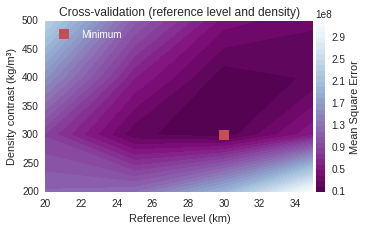

In [89]:
plot_cv_ref_dens(densities, reference_levels, scores_refdens, best_dens, best_ref)

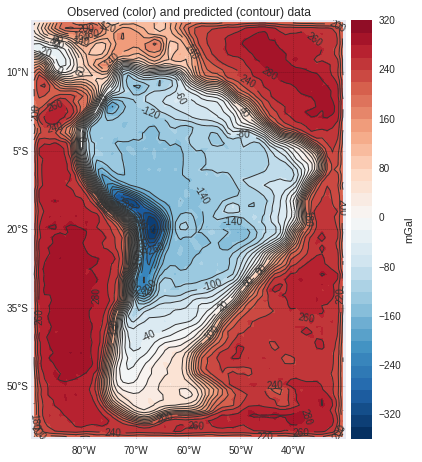

In [90]:
plot_fit(lat, lon, data, solution, bm)

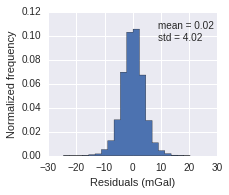

In [91]:
plot_residuals(solution)

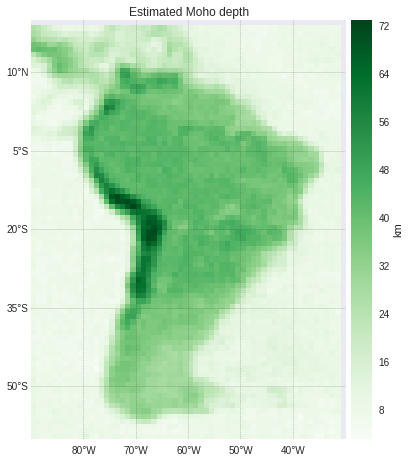

In [92]:
plot_estimate(solution, bm)

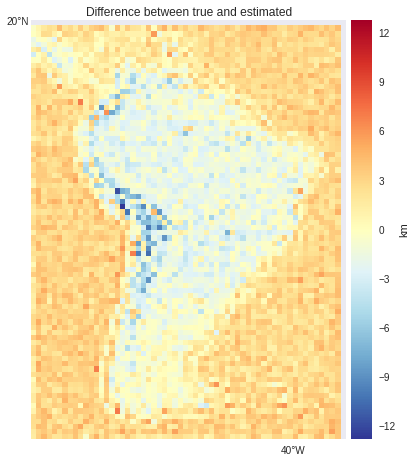

In [93]:
plot_diff(solution, model, bm)

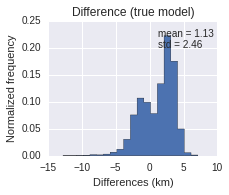

In [94]:
plot_diff_hist(solution, model)

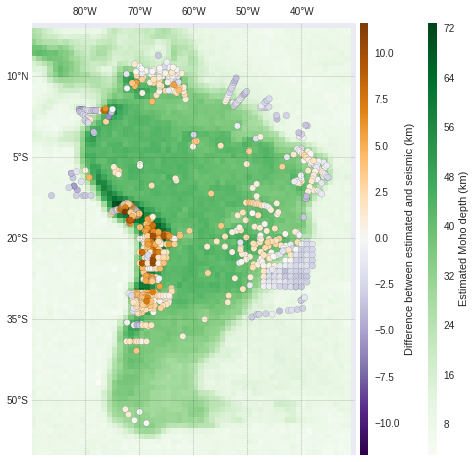

In [95]:
plot_diff_seismic(solution, test_points, bm)

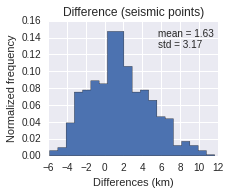

In [96]:
plot_diff_seismic_hist(solution, test_points)

[]()